In [54]:
import numpy as np
from matplotlib import pyplot as plt
from enum import IntEnum
from itertools import islice
from IPython.display import clear_output

In [55]:
class var(IntEnum):
    freq, mag_db, ph_deg = range(3)

In [56]:
# Data interpolation Enable.
iterpEnable = True
N_points = 10000
Ri = 20

In [57]:
file_list = ['uncoated', 'coated']
N = len(file_list)
import_data = np.empty(N, dtype=object)
for n, file_name in enumerate(file_list):
    import_data[n] = np.loadtxt('AP300/' + file_name + '.dat', skiprows=1)
    # Data descaling.
    import_data[n][:,var.mag_db.value] += 20*np.log10(Ri)
    import_data[n][:,var.ph_deg.value] = np.unwrap(import_data[n][:,var.ph_deg.value]*np.pi/180 + np.pi)*180/np.pi

In [58]:
data = np.empty(N, dtype=object)
for n in range(N):
    if iterpEnable:
        data[n] = np.zeros((N_points, len(var)))
        data[n][:,var.freq.value] = np.logspace(np.log10(min(import_data[n][:,var.freq.value])),
                                                np.log10(max(import_data[n][:,var.freq.value])),
                                                N_points)
        for k in islice(var, var.mag_db.value, None):
            data[n][:,k.value] = np.interp(data[n][:,var.freq.value],
                                            import_data[n][:,var.freq.value],
                                            import_data[n][:,k.value])
    else:
        data[n] = import_data[n].copy()

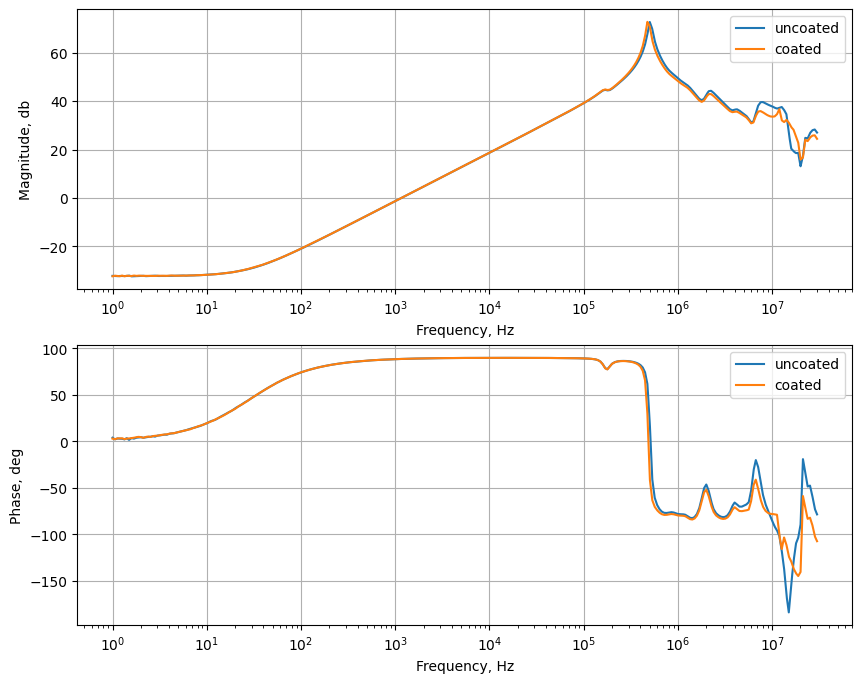

In [59]:
user_ylabel = ['Magnitude, db', 'Phase, deg']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx in range(2):
    ax = axes[idx]
    for n in range(N):
        ax.plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_list[n])
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)

#plt.savefig('readme_img/energy_pywt.png', bbox_inches='tight')
plt.show()

In [60]:
# Parameters.
r = 0.02
L = 136e-6
C = 400e-12
R = 5e3

In [61]:
def reactor_model(freq, L, r, C):
    s = 1j * 2 * np.pi * freq

    # Complex gain.
    #gain_comp = (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) * R) / (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) + R)
    gain_comp = 1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L))
    
    # Magnitude.
    gain_abs = 20*np.log10(np.abs(gain_comp))
    gain_phase = np.unwrap(np.angle(gain_comp))*180/np.pi

    return [gain_abs, gain_phase]

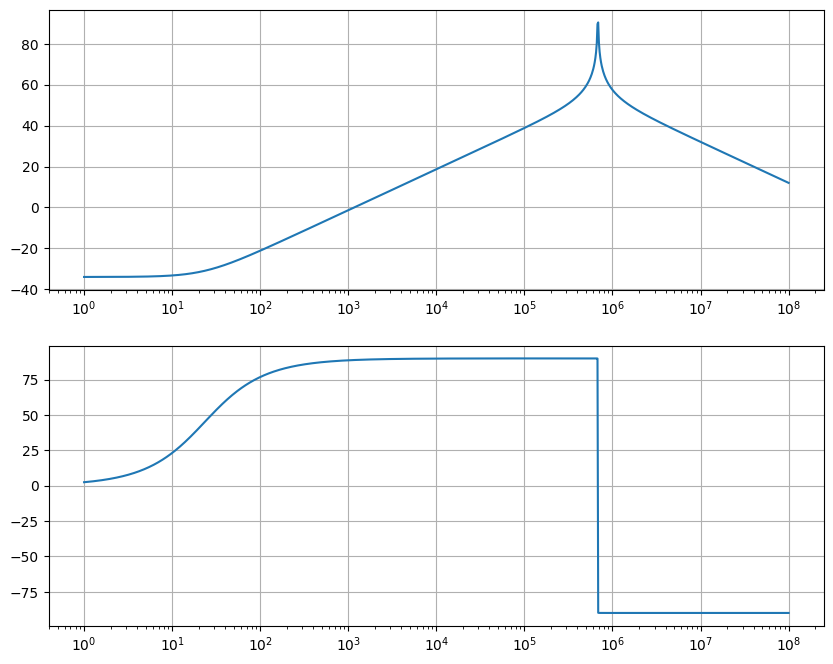

In [62]:
# Create frequency array.
N = int(1e3)
f_min = 1
f_max = 100e6
freq = np.logspace(np.log10(f_min), np.log10(f_max), N)


abs_phase_dataset = reactor_model(freq, L, r, C)#, R)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx in range(2):
    axs[idx].plot(freq, abs_phase_dataset[idx])
    axs[idx].axes.grid(True)
    axs[idx].set_xscale('log')
plt.show()

Амплитудная характеристика принята в качестве отклика.

In [63]:
# freq - частоты.
# y - эталон.
def loss_func(freq, y, w_coeff):
    L = w_coeff[0,0]
    r = w_coeff[0,1]
    C = w_coeff[0,2]
    #R = w_coeff[0,3]

    [abs_dataset, _] = reactor_model(freq, L, r, C)#, R)

    # Функция возвращает сумму квадратов отклонений наблюдений от эталона.
    return np.sum((y - abs_dataset)**2)

In [64]:
w_coeff = np.array([[L, r, C]])
loss_func(data[0][:, var.freq.value], data[0][:, var.mag_db.value], w_coeff)

np.float64(160378.12837167372)

In [70]:
def model_fit(X_train, y_train, learning_rate, delta_tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff = np.array([[L, r, C]])
    
    # Полный буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()

    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    losses = []
        
    for i in range(iteration_max):
        # Элемент оптимизации: ошибку при начальных коэффициентах считаем 1 раз.
        loss_init = loss_func(X_train, y_train, w_coeff)
        for k, w in enumerate(w_coeff.tolist()[0]):

            # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
            w_step = - learning_rate[k] * grad[0,k]

            # Сбрасываем все коэффициенты до исходный значений текущей итерации.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_init,
                              loss_func(X_train, y_train, w_coeff_1),
                              loss_func(X_train, y_train, w_coeff_2)]
            
            # Массив градиента состоит из 3х чисел с индексами [0, 1, 2]. Берем предпоследнее число.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление одного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k].copy()
                
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)

        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)

        if i % 100 == 0:
            clear_output(wait=True)
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('Loss:', np.round(loss,4))
        #if i > 2:
            #if ((losses[-2] - losses[-1]) < delta_tolerance):
            #    break
    
    return w_coeff, losses

In [82]:
weights, losses = model_fit(data[0][:, var.freq.value], data[0][:, var.mag_db.value], learning_rate=[1e-8, 1e-11, 1e-18], delta_tolerance=1e-9)

Iteration: 800
Gradient: [nan nan nan]
Weights: [nan nan nan]
Loss: nan


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=user_figsize)
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.grid()
plt.show

NameError: name 'user_figsize' is not defined

In [ ]:
print('Оптимальные значения коэффициентов:')
w0 = weights[0,1]
a2 = weights[0,0]
print('w0=' + str(np.round(w0, 4)))
print('a2=' + str(np.round(a2, 4)))